<a href="https://colab.research.google.com/github/snikhil17/Mercedes-Benz-Greener-Manufacturing/blob/main/Mercedes_Benz_Greener_Manufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

---


Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include the passenger safety cell with the crumple zone, the airbag, and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium carmakers. Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Daimler’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Daimler’s standards.

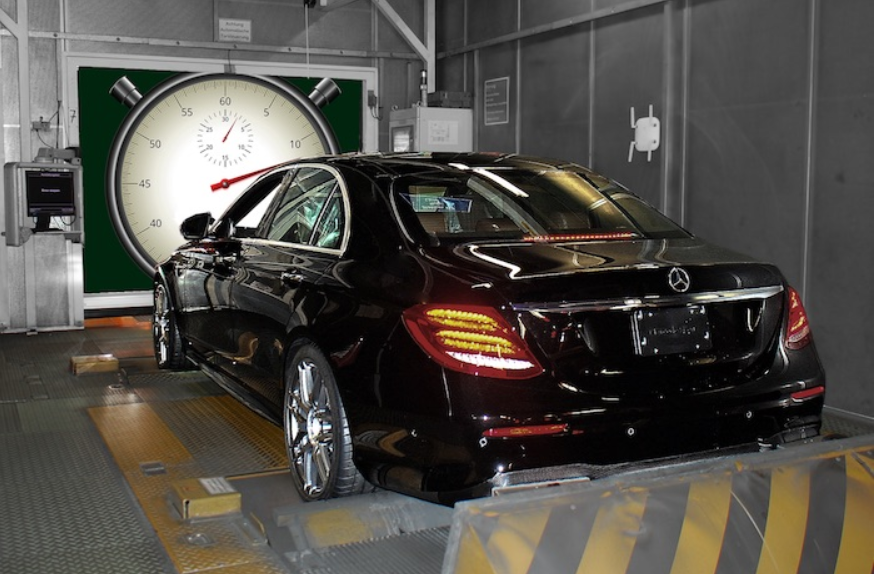

# **Approach**

---
### **Loading Libraries**
### **Loading Data**
### **Exploratory Data Analysis**
  - **Null and Duplicates values**
  - **Data Description**
  - **Removing Zero-Variablity-columns (columns with one value only)**
  - **Categorical variables**

### **Feature Engineering**
  - **One Hot encoding on multiple categorical variables.**
  - **Label Encoding**
  - **Principal Component Analysis**
  - **Box Cox transformation of dependent variable**

### **Modelling: XGBoost**
  - **Randomized Search Cross-Validation for hyper-parameter tuning.**
  - **Xgboost validation set.**
  - **Xgboost on test set.**

### **Evaluation** 

  - **R-squared** 

### **Visualizing the prediction and target values**
### **Conclusion**






# **Loading Required Libraries**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (16, 8)
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scipy import stats
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score,cross_val_predict
from xgboost import XGBRegressor

# **Loading Data**

In [2]:
!wget https://raw.githubusercontent.com/snikhil17/Mercedes-Benz-Greener-Manufacturing/main/train.csv
!wget https://raw.githubusercontent.com/snikhil17/Mercedes-Benz-Greener-Manufacturing/main/test.csv

--2021-10-26 08:28:05--  https://raw.githubusercontent.com/snikhil17/Mercedes-Benz-Greener-Manufacturing/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3220873 (3.1M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   3.07M  --.-KB/s    in 0.08s   

2021-10-26 08:28:05 (37.9 MB/s) - ‘train.csv’ saved [3220873/3220873]

--2021-10-26 08:28:05--  https://raw.githubusercontent.com/snikhil17/Mercedes-Benz-Greener-Manufacturing/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
display(df_train.head(2))
display(df_test.head(2))

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### **Clean the names of the columns by making everything lower_case**

In [5]:
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [6]:
display(df_train.head(2))
display(df_test.head(2))

,id,y,x0,x1,x2,x3,x4,x5,x6,x8,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x345,x346,x347,x348,x349,x350,x351,x352,x353,x354,x355,x356,x357,x358,x359,x360,x361,x362,x363,x364,x365,x366,x367,x368,x369,x370,x371,x372,x373,x374,x375,x376,x377,x378,x379,x380,x382,x383,x384,x385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,id,x0,x1,x2,x3,x4,x5,x6,x8,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,...,x345,x346,x347,x348,x349,x350,x351,x352,x353,x354,x355,x356,x357,x358,x359,x360,x361,x362,x363,x364,x365,x366,x367,x368,x369,x370,x371,x372,x373,x374,x375,x376,x377,x378,x379,x380,x382,x383,x384,x385
0,1,az,v,n,f,d,t,a,w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
print(f"Shape of Training Data: {df_train.shape} \nShape of Testing Data: {df_test.shape} ")

Shape of Training Data: (4209, 378) 
Shape of Testing Data: (4209, 377) 


# **Make lists of Categorical and Numerical Columns**

In [8]:
useful_cols = [col for col in df_train.columns if col not in ['id', 'y', 'kfold']]
categorical = [col for col in useful_cols if df_train[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

# **Exploratory Data Analysis**

## **Checking For Null Values**

In [9]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


## **Checking For Duplicates**

In [10]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


## **Describe the Data**

In [11]:
df_train.describe()

,id,y,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,...,x345,x346,x347,x348,x349,x350,x351,x352,x353,x354,x355,x356,x357,x358,x359,x360,x361,x362,x363,x364,x365,x366,x367,x368,x369,x370,x371,x372,x373,x374,x375,x376,x377,x378,x379,x380,x382,x383,x384,x385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,0.007840,0.099549,0.142789,0.002613,0.086957,0.020670,0.001901,0.004989,0.682585,0.032549,0.043003,0.004514,0.232359,0.011167,0.000238,0.005464,0.232359,0.004514,0.232359,0.033262,0.000238,0.000713,0.011404,0.000238,0.072226,0.011404,0.253267,0.597292,0.012830,0.022333,...,0.022333,0.047517,0.0,0.947256,0.044904,0.338798,0.297220,0.054170,0.002138,0.202899,0.380375,0.179853,0.001188,0.426942,0.031837,0.076503,0.966025,0.520314,0.753861,0.002851,0.002851,0.001188,0.051794,0.062723,0.000475,0.006652,0.014255,0.000475,0.019244,0.227370,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,0.088208,0.299433,0.349899,0.051061,0.281805,0.142294,0.043561,0.070467,0.465526,0.177475,0.202888,0.067043,0.422387,0.105093,0.015414,0.073729,0.422387,0.067043,0.422387,0.179341,0.015414,0.026691,0.106192,0.015414,0.258893,0.106192,0.434934,0.490501,0.112552,0.147782,...,0.147782,0.212768,0.0,0.223549,0.207117,0.473357,0.457089,0.226379,0.046198,0.402205,0.485537,0.384110,0.034450,0.494693,0.175586,0.265832,0.181186,0.499647,0.430812,0.053325,0.053325,0.034450,0.221637,0.242492,0.021796,0.081300,0.118555,0.021796,0.137399,0.419183,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000

### **We will remove Zero Variability Columns from both Test and Train. As those columns will have only one value, which will not be useful when creating model.**

In [12]:
zero_variability_cols_train = [col for col in numerical if np.var(df_train[col]) == 0]
zero_variability_cols_test = [col for col in numerical if np.var(df_test[col]) == 0]

In [13]:
for col in zero_variability_cols_train:
  print(col)
  print(f"Unique Values in Training Data: {df_train[col].unique()}")
  print(f"Unique Values in Test Data: {df_test[col].unique()}")
  print('\n')



x11
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x93
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x107
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x233
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x235
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x268
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x289
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x290
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x293
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x297
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x330
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]


x347
Unique Values in Training Data: [0]
Unique Values in Test Data: [0 1]




In [14]:
for col in zero_variability_cols_test:
  print(col)
  print(f"Unique Values in Training Data: {df_train[col].unique()}")
  print(f"Unique Values in Test Data: {df_test[col].unique()}")
  print('\n')

x257
Unique Values in Training Data: [0 1]
Unique Values in Test Data: [0]


x258
Unique Values in Training Data: [0 1]
Unique Values in Test Data: [0]


x295
Unique Values in Training Data: [0 1]
Unique Values in Test Data: [0]


x296
Unique Values in Training Data: [0 1]
Unique Values in Test Data: [0]


x369
Unique Values in Training Data: [0 1]
Unique Values in Test Data: [0]




## **Observations:**


---
- There are no missing values and Duplicacy in the training and testing data.
- We found that there are different columns in training set and testing set which are zero_variablity_columns. Hence we will remove these columns from both training and testing set. 



In [15]:
zero_variability_cols = zero_variability_cols_train + zero_variability_cols_test

df_train.drop( zero_variability_cols, axis = 1, inplace=True)
df_test.drop( zero_variability_cols, axis = 1, inplace=True)

# Update numerical Columns
numerical = [col for col in useful_cols if col not in categorical and col not in zero_variability_cols]


In [16]:
categorical = [col for col in useful_cols if col in categorical and col not in zero_variability_cols]
useful_features = numerical + categorical
categorical

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x8']

In [17]:
"""Checking the if required columns are removed from training and Testing set."""
display([col for col in numerical if np.var(df_train[col]) == 0])
display([col for col in numerical if np.var(df_test[col]) == 0])

[]

[]

## **Let's Visualize the categorical data.**


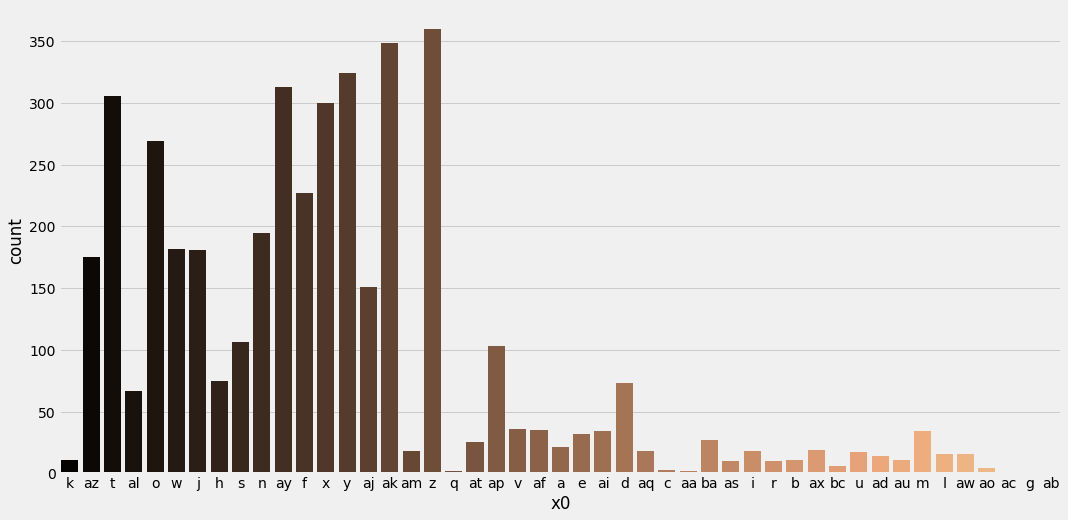

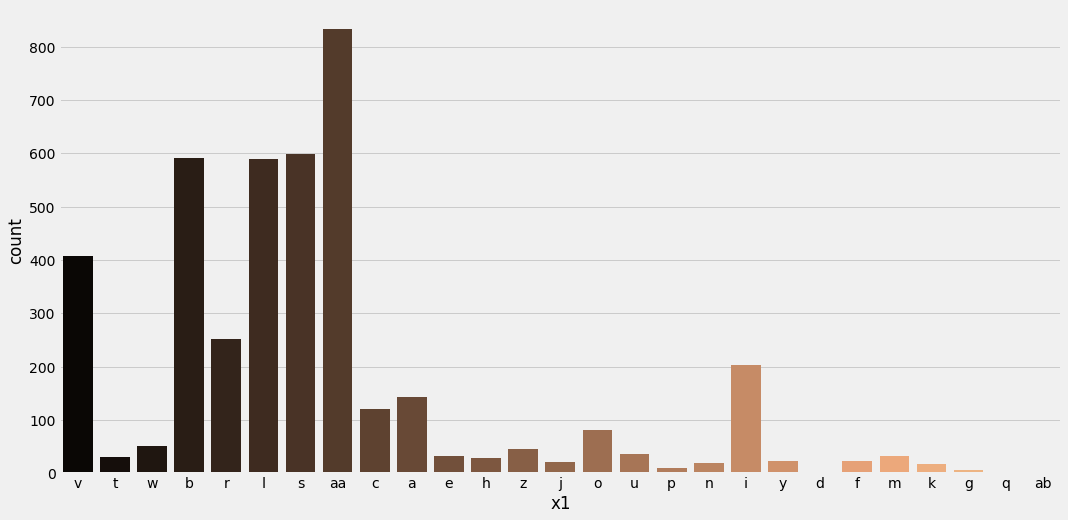

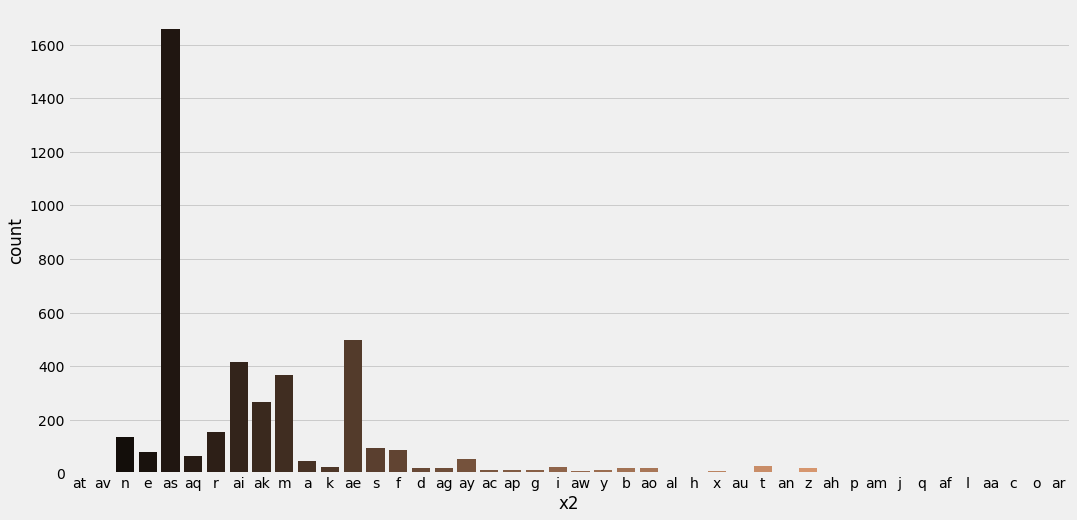

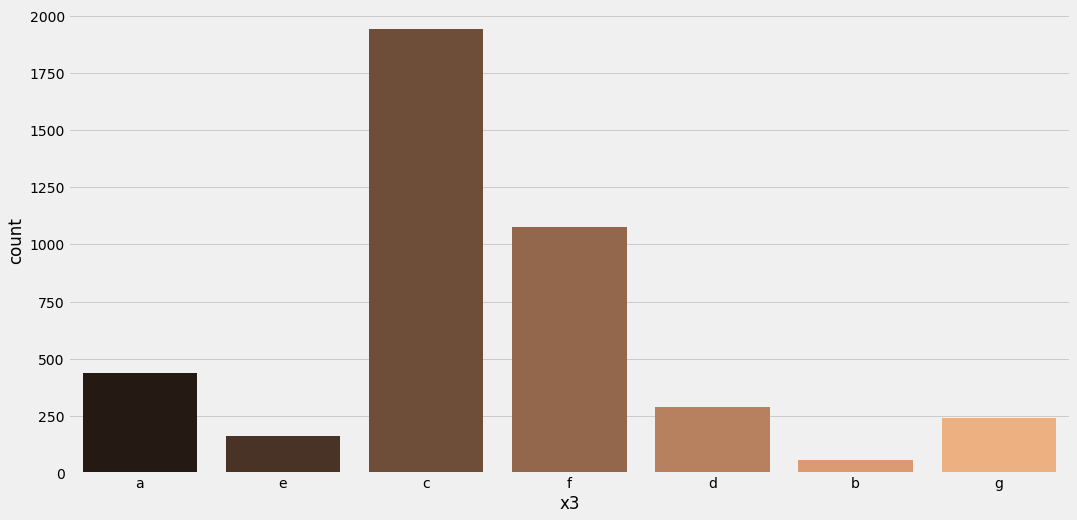

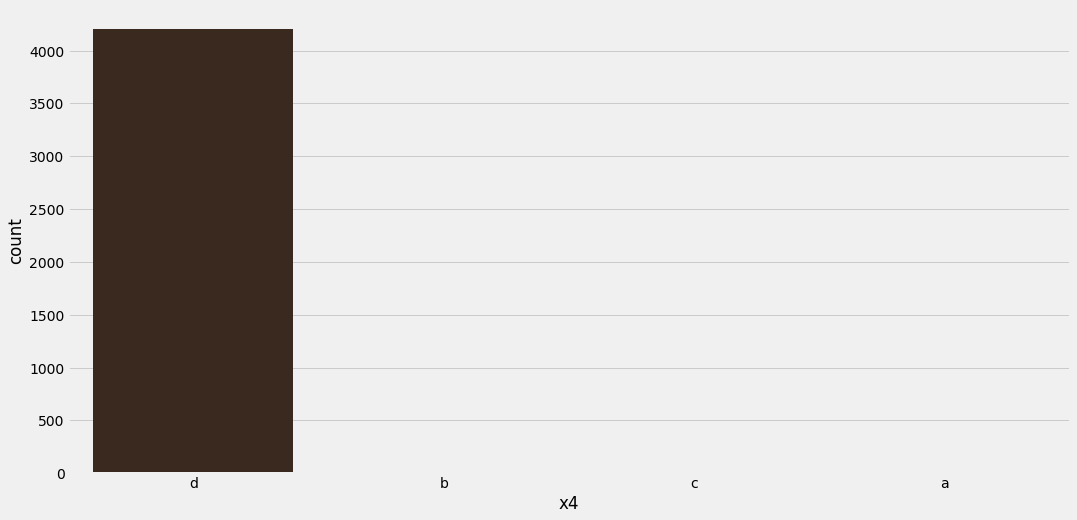

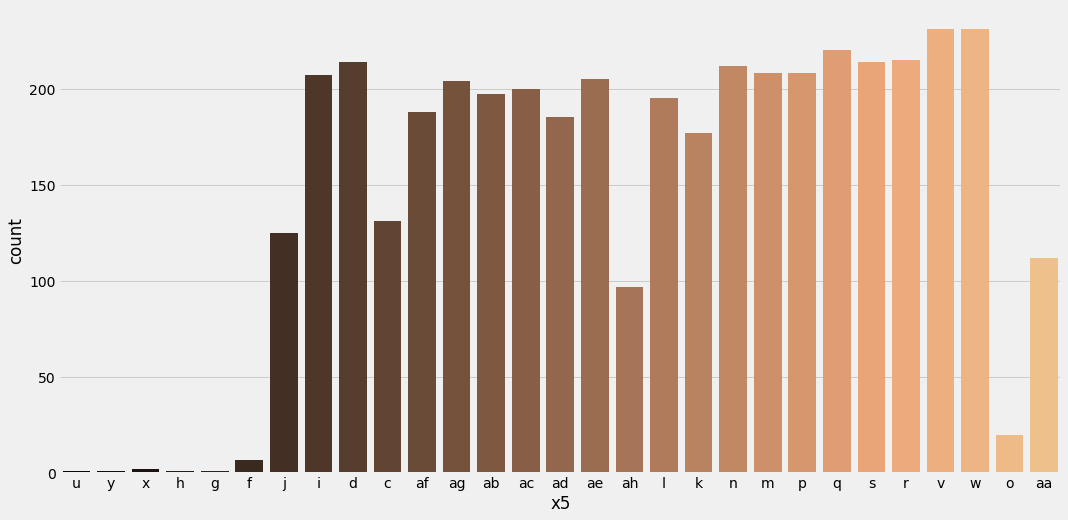

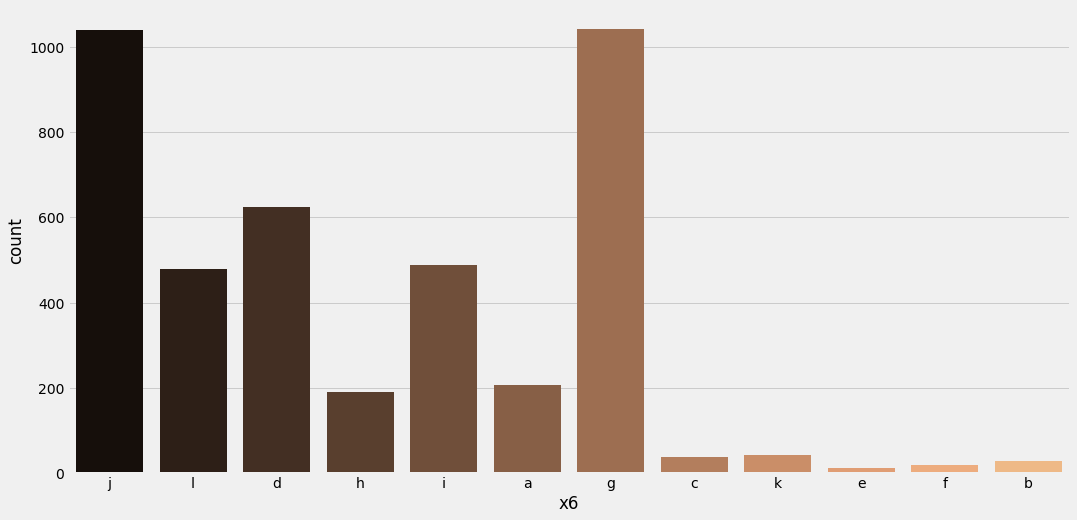

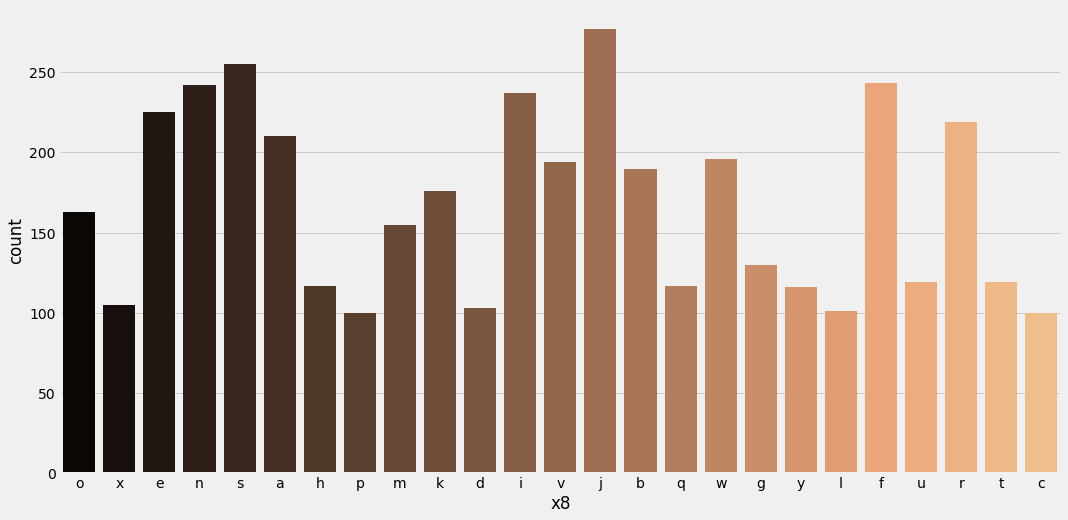

In [21]:
#Let's draw distribution of these variables

for index, col in enumerate(categorical):
    sns.countplot(x=col,data=df_train[categorical],palette = 'copper')   
    plt.show();
    print('\n')



In [19]:
df_train['x2'].nunique()

44

## **Observations:**


---
- Categorical classes have many different classes and some classes are huge in numbers whereas other classes are very small in number.
- We can use label encoder here. But we can also use One Hot Encoding here. For instance consider variable (x2) we can see that it has 44 unique values. Hence values in that variable after label encoding will be 0-43. Hence, we can optimize this. 
- We can use the above observation in our favor. We can include top 10 classes from each categorical variable (wherever 10 classes are present) then perform One Hot Encoding on them. 


# **Feature Engineering**

## **One Hot Encoding and Label Encoding**

In [20]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: df_train[col].nunique(), categorical))
d = dict(zip(categorical, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('x4', 4),
 ('x3', 7),
 ('x6', 12),
 ('x8', 25),
 ('x1', 27),
 ('x5', 29),
 ('x2', 44),
 ('x0', 47)]

In [21]:
# Identify the top 10 most frequent categories of Categorical Columns
for col in categorical:
  print(col)
  display(df_train[col].value_counts().sort_values(ascending=False).head(10))
  print('\n')

x0


z     360
ak    349
y     324
ay    313
t     306
x     300
o     269
f     227
n     195
w     182
Name: x0, dtype: int64



x1


aa    833
s     598
b     592
l     590
v     408
r     251
i     203
a     143
c     121
o      82
Name: x1, dtype: int64



x2


as    1659
ae     496
ai     415
m      367
ak     265
r      153
n      137
s       94
f       87
e       81
Name: x2, dtype: int64



x3


c    1942
f    1076
a     440
d     290
g     241
e     163
b      57
Name: x3, dtype: int64



x4


d    4205
a       2
b       1
c       1
Name: x4, dtype: int64



x5


w    231
v    231
q    220
r    215
s    214
d    214
n    212
p    208
m    208
i    207
Name: x5, dtype: int64



x6


g    1042
j    1039
d     625
i     488
l     478
a     206
h     190
k      43
c      38
b      28
Name: x6, dtype: int64



x8


j    277
s    255
f    243
n    242
i    237
e    225
r    219
a    210
w    196
v    194
Name: x8, dtype: int64

In [22]:
# Define a funtion to peform one hot encoding for the top 10 most frequent categories of Categorical Features
def one_hot_top10(df,feature,top10_categories):
    for category in top10_categories:
        df[feature+'_'+category]=np.where(df_train[feature]==category,1,0)


In [23]:
"""
Create a dict for the top 10 most frequent categories of Categorical Features
Call the function to perform one hot encoding on Categorical Features
verify the train and test set after applying one hot encoding for the Categorical 
"""

var_dict_train ={}

for col in categorical:
  var_dict_train[col] = [x for x in df_train[col].value_counts().sort_values(ascending=False).head(10).index]


display(var_dict_train)

{'x0': ['z', 'ak', 'y', 'ay', 't', 'x', 'o', 'f', 'n', 'w'],
 'x1': ['aa', 's', 'b', 'l', 'v', 'r', 'i', 'a', 'c', 'o'],
 'x2': ['as', 'ae', 'ai', 'm', 'ak', 'r', 'n', 's', 'f', 'e'],
 'x3': ['c', 'f', 'a', 'd', 'g', 'e', 'b'],
 'x4': ['d', 'a', 'b', 'c'],
 'x5': ['w', 'v', 'q', 'r', 's', 'd', 'n', 'p', 'm', 'i'],
 'x6': ['g', 'j', 'd', 'i', 'l', 'a', 'h', 'k', 'c', 'b'],
 'x8': ['j', 's', 'f', 'n', 'i', 'e', 'r', 'a', 'w', 'v']}

In [24]:
for key,val in var_dict_train.items():
  one_hot_top10(df_train,key,val)

for key,val in var_dict_train.items():
  one_hot_top10(df_test,key,val)

df_train.head()

,id,y,x0,x1,x2,x3,x4,x5,x6,x8,x10,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,...,x3_f,x3_a,x3_d,x3_g,x3_e,x3_b,x4_d,x4_a,x4_b,x4_c,x5_w,x5_v,x5_q,x5_r,x5_s,x5_d,x5_n,x5_p,x5_m,x5_i,x6_g,x6_j,x6_d,x6_i,x6_l,x6_a,x6_h,x6_k,x6_c,x6_b,x8_j,x8_s,x8_f,x8_n,x8_i,x8_e,x8_r,x8_a,x8_w,x8_v
0,0,130.81,k,v,at,a,d,u,j,o,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [25]:
df_test.head()

,id,x0,x1,x2,x3,x4,x5,x6,x8,x10,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,...,x3_f,x3_a,x3_d,x3_g,x3_e,x3_b,x4_d,x4_a,x4_b,x4_c,x5_w,x5_v,x5_q,x5_r,x5_s,x5_d,x5_n,x5_p,x5_m,x5_i,x6_g,x6_j,x6_d,x6_i,x6_l,x6_a,x6_h,x6_k,x6_c,x6_b,x8_j,x8_s,x8_f,x8_n,x8_i,x8_e,x8_r,x8_a,x8_w,x8_v
0,1,az,v,n,f,d,t,a,w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [26]:
useful_cols = [col for col in df_train.columns if col not in ['id', 'y', 'kfold']]
categorical = [col for col in useful_cols if df_train[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

## **Now Applying Label Encoder to the train and test set.**

In [27]:
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
  label_encoder.fit(list(df_train[col].values) + list(df_test[col].values))
  df_train[col] = label_encoder.transform(df_train[col])
  df_test[col] = label_encoder.transform(df_test[col])

## **Principal component analysis (PCA)** 
- Instantiate PCA class without specifying n_components.
- Check with how many components PCA can explain the satisfactory variability of the data. 
- Calculate the percentage of variation of each principal components
Assuming we have two principal components PC1 and PC2, then explained_variance_ratio for PC1 = (Variation for PC1/ (Total variation ie (PC1+PC2)))*100
- cumsum() is used to display PC's variation with respect to cumulative percentage

In [28]:
pca=PCA()

pca_train_fit =pca.fit(df_train[useful_cols])
pca_train = pca.transform(df_train[useful_cols])
pca_test = pca.transform(df_test[useful_cols])

In [29]:
pca_train_variation = np.round(pca_train_fit.explained_variance_ratio_.cumsum()*100,decimals=3)
pca_train_variation

array([ 40.574,  62.178,  75.204,  85.924,  94.032,  95.451,  96.149,
        96.575,  96.848,  97.079,  97.301,  97.488,  97.647,  97.789,
        97.91 ,  98.009,  98.1  ,  98.189,  98.264,  98.331,  98.394,
        98.453,  98.508,  98.557,  98.603,  98.647,  98.686,  98.725,
        98.762,  98.797,  98.831,  98.864,  98.895,  98.924,  98.953,
        98.981,  99.008,  99.034,  99.058,  99.08 ,  99.101,  99.122,
        99.142,  99.161,  99.179,  99.197,  99.215,  99.231,  99.248,
        99.264,  99.279,  99.294,  99.308,  99.322,  99.335,  99.348,
        99.361,  99.374,  99.386,  99.397,  99.408,  99.419,  99.43 ,
        99.44 ,  99.451,  99.461,  99.47 ,  99.48 ,  99.49 ,  99.499,
        99.508,  99.517,  99.526,  99.535,  99.544,  99.553,  99.561,
        99.569,  99.578,  99.586,  99.594,  99.602,  99.61 ,  99.617,
        99.625,  99.633,  99.64 ,  99.647,  99.654,  99.661,  99.668,
        99.675,  99.682,  99.689,  99.695,  99.702,  99.708,  99.714,
        99.72 ,  99.

### **Obervation:**

---


- By looking into the array of elements, It is observed that among 427 Principal components, ~90% of variation of the data in train_X dataset is explained by only first 72 principal components .
- lets validate by visualizing scree plot for the first 72 principal components



In [30]:
n_comp = 72
pca = PCA(n_components=n_comp, random_state=7)
pca.fit(df_train[useful_cols])
pca2_results_train = pca.transform(df_train[useful_cols])
pca2_results_test = pca.transform(df_test[useful_cols])

In [31]:
## check the variation for the first 72 principal components 
pca_train_X_variation_72 = np.round(pca.fit(df_train[useful_cols]).explained_variance_ratio_.cumsum()*100,decimals=3)
pca_train_X_variation_72

array([40.574, 62.178, 75.204, 85.924, 94.032, 95.451, 96.149, 96.575,
       96.848, 97.079, 97.301, 97.488, 97.647, 97.789, 97.91 , 98.009,
       98.1  , 98.189, 98.264, 98.331, 98.394, 98.453, 98.508, 98.557,
       98.603, 98.647, 98.686, 98.725, 98.762, 98.797, 98.831, 98.864,
       98.895, 98.924, 98.953, 98.981, 99.008, 99.034, 99.058, 99.08 ,
       99.101, 99.122, 99.142, 99.161, 99.179, 99.197, 99.214, 99.231,
       99.248, 99.264, 99.279, 99.294, 99.308, 99.322, 99.335, 99.348,
       99.361, 99.373, 99.385, 99.397, 99.408, 99.418, 99.429, 99.439,
       99.449, 99.459, 99.468, 99.478, 99.487, 99.496, 99.505, 99.513])

### **Let's visualize the above result using ``scree plot``**
- **Scree plot:** In multivariate statistics, a scree plot is a line plot of the eigenvalues of factors or principal components in an analysis. The scree plot is used to determine the number of factors to retain in an exploratory factor analysis (FA) or principal components to keep in a principal component analysis (PCA). 

Text(0, 0.5, 'Cumulative percentage of explained variance ')

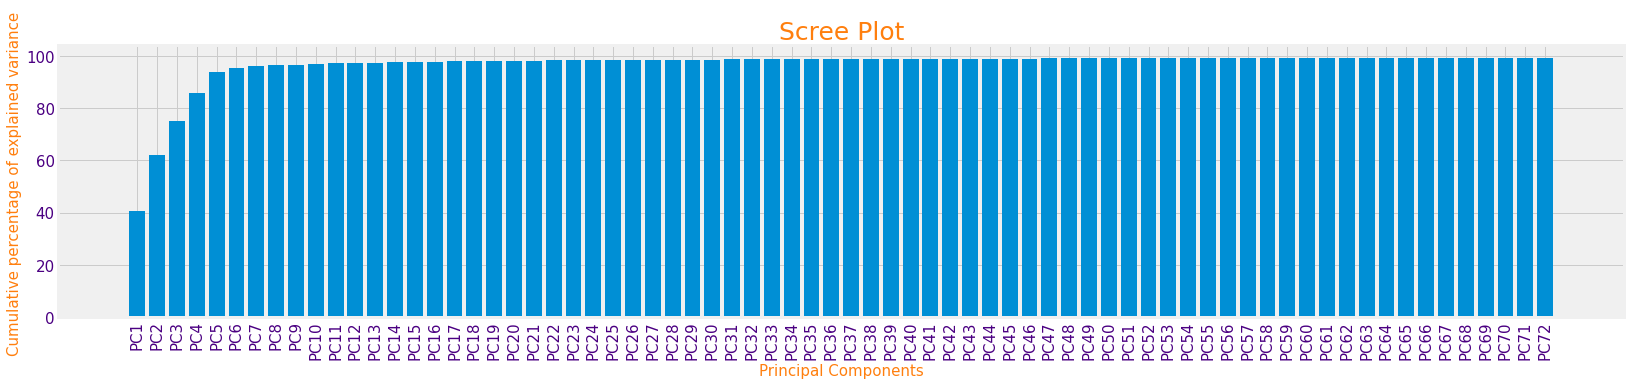

In [32]:
labels = ['PC' + str(x) for x in range(1, len(pca_train_X_variation_72)+1)]

# generate the scree plot
## 
plt.figure(figsize=(25,5))
##
plt.bar(x=range(1, len(pca_train_X_variation_72)+1), height=pca_train_X_variation_72,tick_label=labels)
##
plt.xticks(rotation=90, color='indigo', size=15)
plt.yticks(rotation=0, color='indigo', size=15)
##
##################
plt.title('Scree Plot',color='tab:orange', fontsize=25)
###################
##
plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
##

## **Observation**
- Above scree plot shows that considering first 72 principal components should be sufficient to represent the training dataset

## **BOX-COX transformation**
- A **Box Cox transformation** is a transformation of non-normal dependent variables into a normal shape.

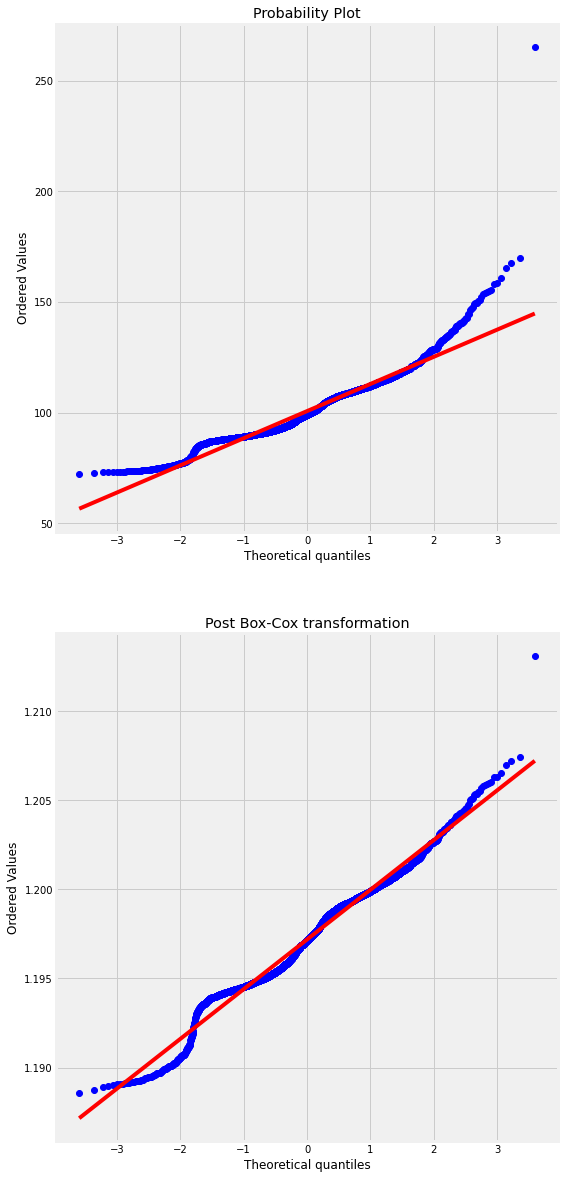

In [33]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(211)
prob = stats.probplot(df_train["y"], dist=stats.norm,plot=ax1)
ax2 = fig.add_subplot(212)
xt, lambda_param = stats.boxcox(df_train["y"])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Post Box-Cox transformation')
plt.subplots_adjust(bottom=-3)

In [34]:
df_train.y,lambda_param = stats.boxcox(df_train.y)
lambda_param

-0.8156623537257063

# **Modelling: XGBoost** 

## **Using ``RandomizedSearchCV`` for hyper-parameter tuning**

In [35]:
%%time
xgb_reg = XGBRegressor(objective = 'reg:squarederror', tree_method="gpu_hist", gpu_id=0, predictor="gpu_predictor")

#To find best XGBoost Parameters
params={ 'learning_rate'   : [0.001,0.01,0.05, 0.1] ,
         'max_depth'       : [3,5,6,7,10],
         'n_estimators'    : [7000,5000,9000],
         'gamma'           : [1e-2,1e-3,0,0.1,0.01,0.5,1],
         'colsample_bytree': [0.1,0.5,0.7,1],
         'subsample'       : [0.2,0.3,0.5,1],
         'reg_lambda'      : list(stats.loguniform.rvs(1e-2, 1e0, size=3)),
         'reg_alpha'       : list(stats.loguniform.rvs(1e-2, 1e0, size=3))        
        }



# Using Random search of parameters with 10 fold cross validation
# Improve the predictions using cross validation to optimize the parameters
Random_Search=RandomizedSearchCV(xgb_reg,params,cv=7, scoring='r2', return_train_score=True, n_jobs=-1,verbose=1) 


# Fit the training set to the Randon_Search to obtain the best estimators and parameters.
Random_Search.fit(pca2_results_train,df_train['y'].values)



Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 51.1min finished


CPU times: user 57.9 s, sys: 1.36 s, total: 59.3 s
Wall time: 51min 52s


In [37]:
# Print the best estimator
best_estimators = Random_Search.best_estimator_
best_estimators

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.001, gpu_id=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=9000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             predictor='gpu_predictor', random_state=0,
             reg_alpha=0.06257530400729013, reg_lambda=0.27220135998501516,
             scale_pos_weight=1, seed=None, silent=None, subsample=0.2,
             tree_method='gpu_hist', verbosity=1)

In [38]:
#Print the best parameters
Random_Search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.001,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 9000,
 'reg_alpha': 0.06257530400729013,
 'reg_lambda': 0.27220135998501516,
 'subsample': 0.2}

## **Using parameters suggested by RandomizedSearchCV.**
- **For validation the r-squared we use ``cross_val_score`` and create 7 folds, as the same were created when tuning the parameters in ``RandomizedSearchCV``**

In [39]:
%%time

# Instantiate the XGBoost classifier with the best estimators and parameters
xgb_reg=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.001, gpu_id=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=9000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             predictor='gpu_predictor', random_state=0,
             reg_alpha=0.06257530400729013, reg_lambda=0.27220135998501516,
             scale_pos_weight=1, seed=None, silent=None, subsample=0.2,
             tree_method='gpu_hist', verbosity=1)

r2_Score = cross_val_score(xgb_reg,pca2_results_train,df_train['y'].values,scoring='r2',cv=7)
r2_Score

CPU times: user 5min 31s, sys: 1.51 s, total: 5min 32s
Wall time: 5min 31s


In [40]:
r2_Score

array([0.65695281, 0.54037588, 0.609974  , 0.66112934, 0.53948717,
       0.64897795, 0.66586822])

## **Mean of Cross-val-score w.r.t r-squared**

In [41]:
# Print the mean r2_score
print('r2_score of the model with cross validation is:',round(r2_Score.mean(),6))

r2_score of the model with cross validation is: 0.617538


## **Predicting the Train and Test set using the final model created.**

In [42]:
%%time
# Fit the training data
xgb_reg.fit(pca2_results_train,df_train['y'].values)

# predict the time taken by car to pass testing on train and test data
x_train_preds = xgb_reg.predict(pca2_results_train)
X_test_pred = xgb_reg.predict(pca2_results_test)
X_test_pred 

CPU times: user 48.7 s, sys: 175 ms, total: 48.9 s
Wall time: 48.7 s


## **Inversing BoxCox Transformation**

In [43]:
"""Inversing the Boxcox"""
X_test_pred = inv_boxcox(X_test_pred, -0.8156623537257063)



"""Inversing the Boxcox"""
x_train_preds = inv_boxcox(x_train_preds, -0.8156623537257063)


"""Inversing the Boxcox"""
df_train['y'] = inv_boxcox(df_train['y'], -0.8156623537257063)


## **Visualizing the ``r-squared values``**

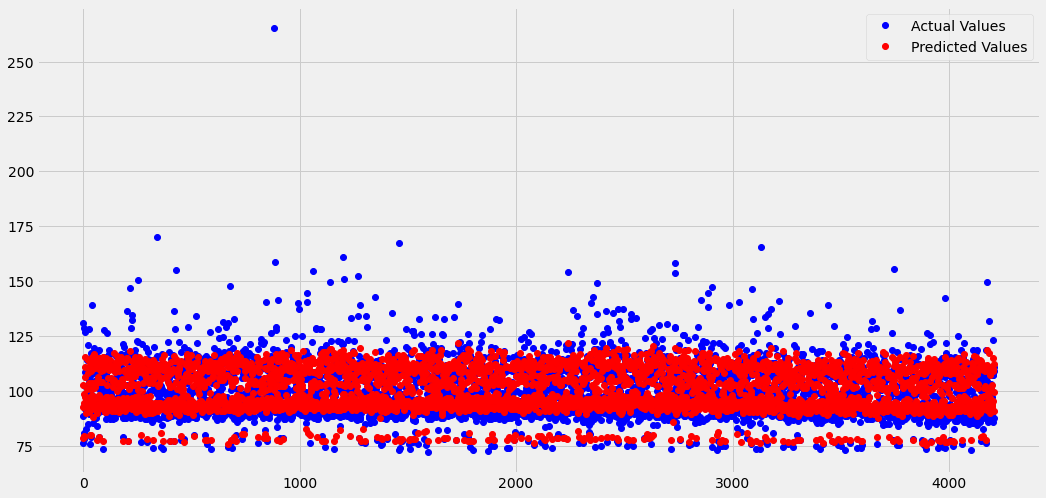

In [48]:
plt.figure()
plt.plot(df_train['y'].values, 'o', color = 'blue', label = 'Actual Values')
plt.plot(x_train_preds, 'o', color = 'red', label = 'Predicted Values')
plt.legend();

## **Conclusion:**


---
- **We got mean r-squared on validation set as 0.617538 which is close to 62%.**
- **Initially we had 432 variables and PCA helped us to scale the data to 72 variables which clearly explained the data.**
- **Randomized CV helped us to obtain best parameters for XGBoost. Other tools like Optuna may also be used.**
- **Moreover, we could have used blending and stacking for better predictions, but with precaution as those can cause the model to overfit easily.**
- **Following notebook shows how we could have done this in another way, using Optuna, Blending and Stacking.**
- **Link:**
  - **Blending:** https://www.kaggle.com/snikhil17/tuning-blending-of-xgb-catboost-lightgbm
  - **Stacking:** https://www.kaggle.com/snikhil17/final-stacking
- **Boxcox transformation helped in better predictions.** 
- **Reason for reversing the box-cox:**
  - **We want to see the actual values rather than the converted values.**
  - **Plot of Predictions and Target values makes more sense with orginial values rather than visualizing transformed varlues**
